In [1]:
%config Completer.use_jedi = False

In [12]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_6"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}



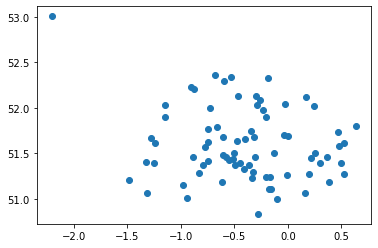

In [13]:
plt.scatter(points_coordinate[:,1],points_coordinate[:,0])

In [4]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[]}


amount_of_runs = 30
amount_of_evaluations = 10000
logpath = "parameter_data/{}/".format(dataset)

mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})


In [5]:
logpath

'parameter_data/UK75_1/'

# Paremeter Test 

# Simulated Annealing

In [26]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA = []
for x in mutation_arange:
    parameter_list_SA.append({"mutation":np.round(x,2)})



parameter_data_SA = []
computation_times_SA = []
results_SA = []
sa_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_SA):
    plot_data_SA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_SA = VRP(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
       
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_SA)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * amount_of_runs
        performance_observer_SA.currentEpoch = (index*amount_of_runs) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()        
        store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)
        
    new_Row = pd.DataFrame.from_dict(plot_data_SA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)#["Parameters"] = param
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    
    
    sa_log_data_DF = pd.concat([sa_log_data_DF,new_Row])
    
    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})

sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:150 of 150
Evaluations: 10000/10000
Params: {'mutation': 0.9}
IGD:3076.1523599236575
Best fitness: 871.2446                          
Best total fuel consumption:433.18 
Best total drive time:3045.5                          
Computing time: 12.42s
Average computing speed: 805.17it/s                          
Current Route:[['V4', 54, 41, 71, 62, 66, 72, 2], ['V3', 18, 61, 50, 23, 74, 57, 48, 4], ['V2', 47, 33, 13, 12, 11, 45], ['V0', 34, 38, 30, 70, 24, 26, 65, 1], ['V5', 69, 55, 67, 42, 59, 52, 44, 14, 37, 45], ['V6', 43, 51, 19, 5], ['V7', 7, 39, 25, 16, 9, 17, 75, 27, 32], ['V1', 22, 56, 63, 53, 4], ['V8', 58, 28, 36, 2], ['V10', 3, 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []
Violation:0
Vehicle Amount:11


In [29]:
sa_log_data_DF.to_csv("{}/SA.csv".format(logpath))

# Genetic Algorithm

In [6]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameter_list_GA = genetic_algorithms_parameters

GA_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))

for index,param in enumerate(parameter_list_GA):
    plot_data_GA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_GA = VRP(data_model_input_single_objective)
        problem_GA.name = "GA"
        problem_GA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                        population_size=param["population_size"],
                        offspring_population_size=param["population_size"],
                        mutation=PermutationSwapMutation(param["mutation"]),
                        crossover=PMXCrossover(param["crossover"]),
                        selection=BestSolutionSelection(),
                        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                        ,population_evaluator=MultiprocessEvaluator()
                        )


        performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_GA)
        performance_observer_GA.maxEpochs= len(parameter_list_GA) * amount_of_runs
        performance_observer_GA.currentEpoch = (index*amount_of_runs) + x
        algorithm_GA.observable.register(observer=performance_observer_GA)
        start_time = datetime.now() 
        algorithm_GA.run()
        run_time = datetime.now() - start_time
        solutions_GA = algorithm_GA.get_result()
        

        store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
        
    new_Row = pd.DataFrame.from_dict(plot_data_GA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    
    
    GA_log_data_DF = pd.concat([GA_log_data_DF,new_Row])
    

#saveParameterData(logPath,"GA_data_10_pop",parameter_data_GA)

Epoch:1350 of 1350
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30}
IGD:2946.644915378155
Best fitness: 885.5549                          
Best total fuel consumption:420.87 
Best total drive time:2916.43                          
Computing time: 13.21s
Average computing speed: 758.45it/s                          
Current Route:[['V2', 47, 33, 23, 22, 4], ['V1', 63, 56, 19, 61, 50, 74, 57, 48, 4], ['V7', 17, 75, 32], ['V10', 69, 12, 44, 14, 37, 45], ['V4', 13, 24, 26, 53, 42, 59, 65, 1], ['V5', 70, 38, 52, 30, 67, 55, 1], ['V3', 18, 43, 51, 39, 9, 62, 41, 54, 11, 34, 45], ['V9', 25, 66, 27, 16, 7, 72, 2], ['V6', 36, 28, 58, 2], ['V0', 3, 71, 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []
Violation:0
Vehicle Amount:11


Process ForkPoolWorker-5398:
Process ForkPoolWorker-5399:
Process ForkPoolWorker-5400:
Traceback (most recent call last):
Process ForkPoolWorker-5397:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiproc

In [7]:
GA_log_data_DF.to_csv("{}/GA.csv".format(logpath))

# NSGA-II

In [8]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_NSGAII = genetic_algorithms_parameters#[{"mutation":0.8,"crossover":0.5,"population_size":20}]#,{"mutation":0.8,"crossover":0.5}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_NSGAII.append({"mutation":round(x,2),"crossover":round(y,2)})


NSGA2_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_NSGAII):
    plot_data_NSGAII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_NSGAII = VRP(data_model_input_multi_objective)
        problem_NSGAII.name = "NSGA-II"
        problem_NSGAII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                                population_size=param["population_size"],
                                offspring_population_size=param["population_size"],
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator()

                                   )

        performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAII)
        performance_observer_NSGAII.maxEpochs= len(parameter_list_NSGAII) * amount_of_runs
        performance_observer_NSGAII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
        algorithm_NSGAII.run()
        
        solutions_NSGAII = algorithm_NSGAII.get_result()
        front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
        
        store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,front_NSGAII[0])
        
    new_Row = pd.DataFrame.from_dict(plot_data_NSGAII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    NSGA2_log_data_DF = pd.concat([NSGA2_log_data_DF,new_Row])



Epoch:1350 of 1350
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:615.1945102146476
Best fitness: 429.2566 --- 453.8667                        
Best total fuel consumption:429.26 
Computing time: 15.06s                        
Average computing speed: 665.25it/s
Current Route:[['V0', 63, 56, 22, 19, 5], ['V5', 12, 45], ['V2', 50, 23, 57, 48, 74, 33, 47, 2], ['V3', 18, 71, 3, 54, 34, 11, 41, 45], ['V1', 69, 24, 26, 53, 65, 42, 59, 52, 67, 55, 1], ['V10', 37, 44, 70, 30, 38, 14, 45], ['V7', 9, 16, 7, 39, 43, 51, 61, 5], ['V8', 25, 17, 75, 27, 66, 62, 5], ['V9', 72, 2], ['V6', 36, 28, 58, 2], ['V4', 13, 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:12


In [9]:
NSGA2_log_data_DF.to_csv("{}/NSGA2.csv".format(logpath))

# NSGA-III

In [10]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = genetic_algorithms_parameters

NSGA3_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=param["population_size"],
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])
        
        
    new_Row = pd.DataFrame.from_dict(plot_data_NSGAIII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    NSGA3_log_data_DF = pd.concat([NSGA3_log_data_DF,new_Row])
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:1350 of 1350
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:599.9424368462919
Best fitness: 417.4874 --- 433.95                        
Best total fuel consumption:417.49 
Computing time: 16.16s                        
Average computing speed: 619.9it/s
Current Route:[['V8', 19, 56, 22, 23, 63, 53, 4], ['V2', 18, 50, 74, 47, 33, 57, 48, 4], ['V5', 52, 38, 54, 13, 11, 41, 45], ['V1', 69, 24, 26, 59, 42, 67, 55, 65, 1], ['V0', 30, 70, 12, 44, 14, 37, 45], ['V7', 9, 16, 25, 7, 43, 39, 61, 51, 62, 17, 75, 27, 66, 72, 2], ['V6', 36, 28, 58, 2], ['V10', 3, 71, 64, 45], ['V4', 34, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:10


In [11]:
NSGA3_log_data_DF.to_csv("{}/NSGA3.csv".format(logpath))

# UNSGA-III

In [74]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_UNSGAIII = genetic_algorithms_parameters
UNSGA3_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_UNSGAIII):
    plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_UNSGAIII = VRP(data_model_input_multi_objective)
        problem_UNSGAIII.name = "NSGA-III"
        problem_UNSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                                population_size=param["population_size"],
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_UNSGAIII)
        performance_observer_UNSGAIII.maxEpochs= len(parameter_list_UNSGAIII) * amount_of_runs
        performance_observer_UNSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
        algorithm_UNSGAIII.run()
        
        solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
        front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)
        
        store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,front_UNSGAIII[0])
        
        
    new_Row = pd.DataFrame.from_dict(plot_data_UNSGAIII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    UNSGA3_log_data_DF = pd.concat([UNSGA3_log_data_DF,new_Row])
        
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:1350 of 1350
Evaluations: 5010/5000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:312.3536294554789
Best fitness: 237.0424 --- 209.8                        
Best total fuel consumption:237.04 
Computing time: 5.48s                        
Average computing speed: 914.34it/s
Current Route:[['V0', 42, 33, 30, 19, 34, 29, 2], ['V2', 46, 37, 44, 2], ['V6', 48, 4], ['V4', 11, 18, 39, 20], ['V7', 47, 8, 2], ['V3', 24, 27, 26, 50, 31, 2], ['V9', 36, 17, 25, 13, 14, 16, 38, 2], ['V8', 7, 45], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:11


In [75]:
UNSGA3_log_data_DF.to_csv("{}/UNSGA3.csv".format(logpath))

# IBEA

In [76]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_IBEA =genetic_algorithms_parameters

IBEA_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_IBEA):
    plot_data_IBEA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_IBEA = VRP(data_model_input_multi_objective)
        problem_IBEA.name = "IBEA"
        problem_IBEA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_IBEA = IBEA(problem=problem_IBEA,
                                population_size=param["population_size"],
                                offspring_population_size=param["population_size"],
                                kappa =1,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),
                                   )
        
        performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_IBEA)
        performance_observer_IBEA.maxEpochs= len(parameter_list_IBEA) * amount_of_runs
        performance_observer_IBEA.currentEpoch = (index*amount_of_runs) + x
         
        
        algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
        algorithm_IBEA.run()
        
        solutions_IBEA = algorithm_IBEA.get_result()
        front_IBEA = get_non_dominated_solutions(solutions_IBEA)
        store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])
    
    new_Row = pd.DataFrame.from_dict(plot_data_IBEA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    IBEA_log_data_DF = pd.concat([IBEA_log_data_DF,new_Row])
    
    
ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:1350 of 1350
Evaluations: 5010/5000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:308.8670195012722
Best fitness: 226.6777 --- 209.8                        
Best total fuel consumption:226.68 
Computing time: 7.63s                        
Average computing speed: 656.93it/s
Current Route:[['V0', 42, 30, 33, 19, 34, 29, 2], ['V10', 7, 37, 31, 2], ['V7', 48, 4], ['V4', 11, 18, 39, 20], ['V6', 47, 46, 8, 2], ['V2', 38, 50, 44, 26, 27, 2], ['V8', 17, 25, 13, 14, 16, 24, 2], ['V9', 36, 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:10


Process ForkPoolWorker-27002:
Process ForkPoolWorker-27003:
Process ForkPoolWorker-27004:
Process ForkPoolWorker-27001:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

KeyboardInterrupt: 

In [17]:
IBEA_log_data_DF.to_csv("{}/IBEA.csv".format(logpath))